# Plot Eval metrics

In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import joblib
import re
import seaborn as sns
from typing import Callable
from matplotlib.patches import Rectangle
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.dataloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.utils.eval_metric import eval_gigaword, eval_dailymail, evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "LLAMA-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

# Assign linestyle to model
model_linestyle = {
    # "mistral-7b": "-",
    # "llama-7b": "--",
    # "gpt3.5": ":",
    # "gpt4": " ",
    # "mixtral": "-.",
    "model": "-",
}

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]


In [5]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12, 3 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x="num_examples",
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.05, r'Conversation History Length $L$', ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        # plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [6]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
        df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
    return df

In [7]:
def sensitivity(df: pd.DataFrame):
    """Calculate the sensitivity of the model"""
    df["sensitivity"] = np.nan
    metric = "base_likelihood"
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["num_examples"] == 0)][metric].values
        # filter nan
        baseline_metric = baseline_metric[~np.isnan(baseline_metric)]
        if len(baseline_metric) > 0:
            baseline_metric = baseline_metric[0]
        else:
            continue
        # print(baseline_metric)
        tau = np.exp(row.base_likelihood - baseline_metric)
        tau = 1 / tau
        df.loc[row.Index, "sensitivity"] = tau
    return df

In [8]:
def results_latex_table(df: pd.DataFrame, columns: list[str], task: str, num_examples: int = 5):
    """Print a dataframe as a latex table
    
    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      dataset | model | metric1 | metric2 | ...
    """
    # Sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets

    # Print header
    print("CH-Task & Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    for dataset in datasets:
        print(f"{dataset_label[dataset]} ")
        df_ds = df[df["incontext_set"] == dataset]
        for model, df_model in df_ds.groupby("model"):
            # print model
            print(f"& {model_label[model]} & ", end="")
            # filter by number of examples
            df_model = df_model[df_model["num_examples"] == num_examples]
            # extract relevant columns
            try:
                values = df_model[columns].values[0]
                # print values
                # make italics if it's the task
                if dataset == task:
                    print(" & ".join(["{-}" if np.isnan(v) else f"\emph{{{v:.2f}}}" for v in values]) + r" \\")
                else:
                    print(" & ".join(["{-}" if np.isnan(v) else f"{v:.2f}" for v in values]) + r" \\")
            except IndexError:
                print(" & ".join(["{-}"] * len(columns)) + r" \\")
            
        if dataset != datasets[-1]:
            print(r"\midrule")
        if dataset == task:
            print(r"\midrule")

In [63]:
def zero_shot_latex_table(
    df: pd.DataFrame, columns: list[str], task: str, num_examples: int = 0, fmts: None = None
):
    """Print a dataframe as a latex table (for zero-shot results)

    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      model | metric1 | metric2 | ...
    """
    # Sort datasets
    # datasets = sorted(list(df["incontext_set"].unique()))
    # datasets.remove(task)
    # datasets = [task] + datasets

    # Set string formatting
    if fmts is None:
        fmts = [".2f"] * len(columns)

    # Print header
    print("Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    # filter by number of examples
    df = df[df["num_examples"] == num_examples]
    # filter by task dataset
    df = df[df["incontext_set"] == task]

    for model, df_model in df.groupby("model"):
        # print model
        print(f"{model_label[model]} & ", end="")
        # extract relevant columns
        try:
            values = df_model[columns].values[0]
            # print values            
            print(
                " & ".join(
                    ["{-}" if np.isnan(v) else f"{v:{fmt}}" for v, fmt in zip(values, fmts)]
                )
                + r" \\"
            )
        except IndexError:
            print(" & ".join(["{-}"] * len(columns)) + r" \\")

In [52]:
print(f"{1.0:.0f}")

1


In [10]:
print(rf"\emph{{}}")

\emph{}


### Evaluate on MMLU Human Ageing

In [66]:
mmlu_age = MMLUHumanAgingDataLoader()
mmlu_age_ref_data = mmlu_age.load_test_reference()
mmlu_age_results = get_results_for_evalset("mmlu-age", mmlu_age_ref_data, use_cached=True)
mmlu_age_df = pd.DataFrame(mmlu_age_results)
print(len(mmlu_age_df))
mmlu_age_df.head()

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Removing large training set examples
Original training set size:  26
New Training set size:  26


Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Model: gpt3.5 is missing eval set ../experiments/gpt3.5/eval_data_mmlu-age
Model: gpt4 is missing eval set ../experiments/gpt4/eval_data_mmlu-age
56


,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,137,1,222,mistral-7b,mmlu-age,3,-1.123342
1,138,2,222,mistral-7b,mmlu-age,6,-1.128903
2,123,0,222,mistral-7b,mmlu-age,0,-1.046391
3,140,1,222,mistral-7b,mmlu-age,4,-1.121651
4,135,1,222,mistral-7b,mmlu-age,2,-1.080061


In [67]:
mmlu_age_df.head()

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,137,1,222,mistral-7b,mmlu-age,3,-1.123342
1,138,2,222,mistral-7b,mmlu-age,6,-1.128903
2,123,0,222,mistral-7b,mmlu-age,0,-1.046391
3,140,1,222,mistral-7b,mmlu-age,4,-1.121651
4,135,1,222,mistral-7b,mmlu-age,2,-1.080061


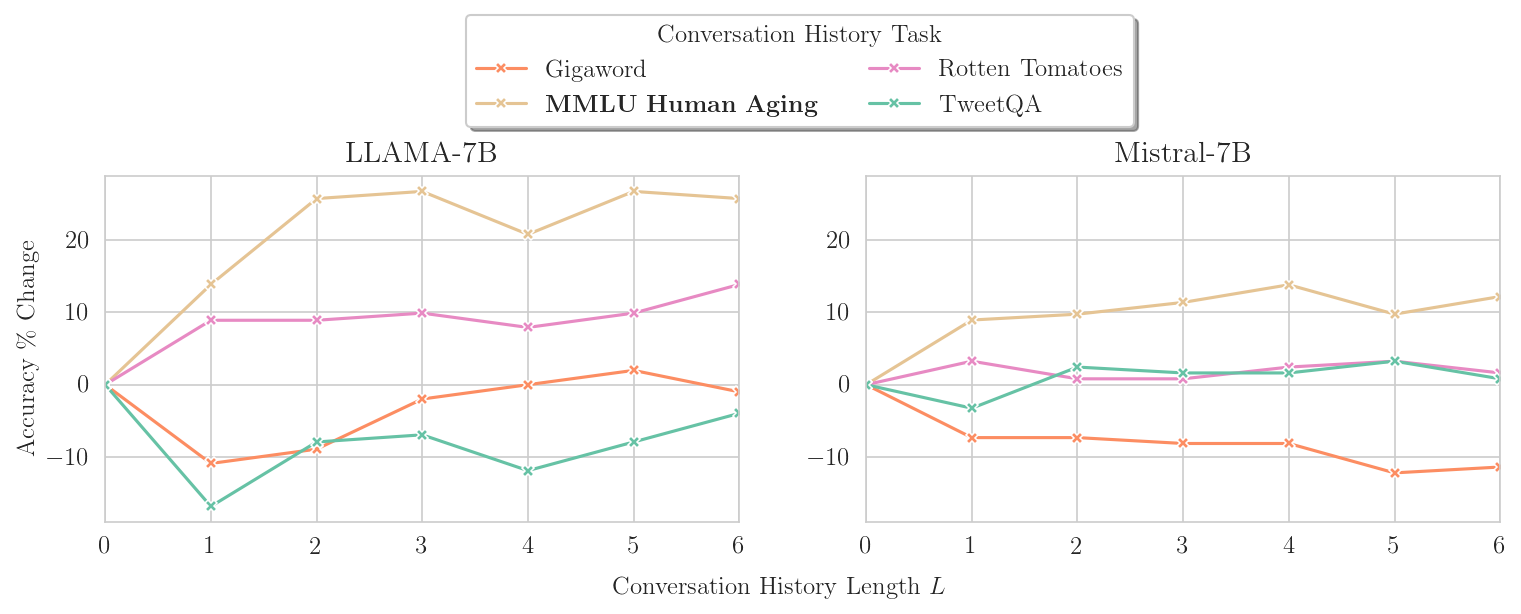

In [68]:
mmlu_age_df["acc"] = mmlu_age_df["matches"] / mmlu_age_df["total"]
mmlu_age_df = df_metric_pct_change(mmlu_age_df, "acc")
df = mmlu_age_df.rename(columns={"acc_pct_change": r"Accuracy \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Accuracy \% Change"], 
  save_path=Path("mmlu-age/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.65, 1.5),
)

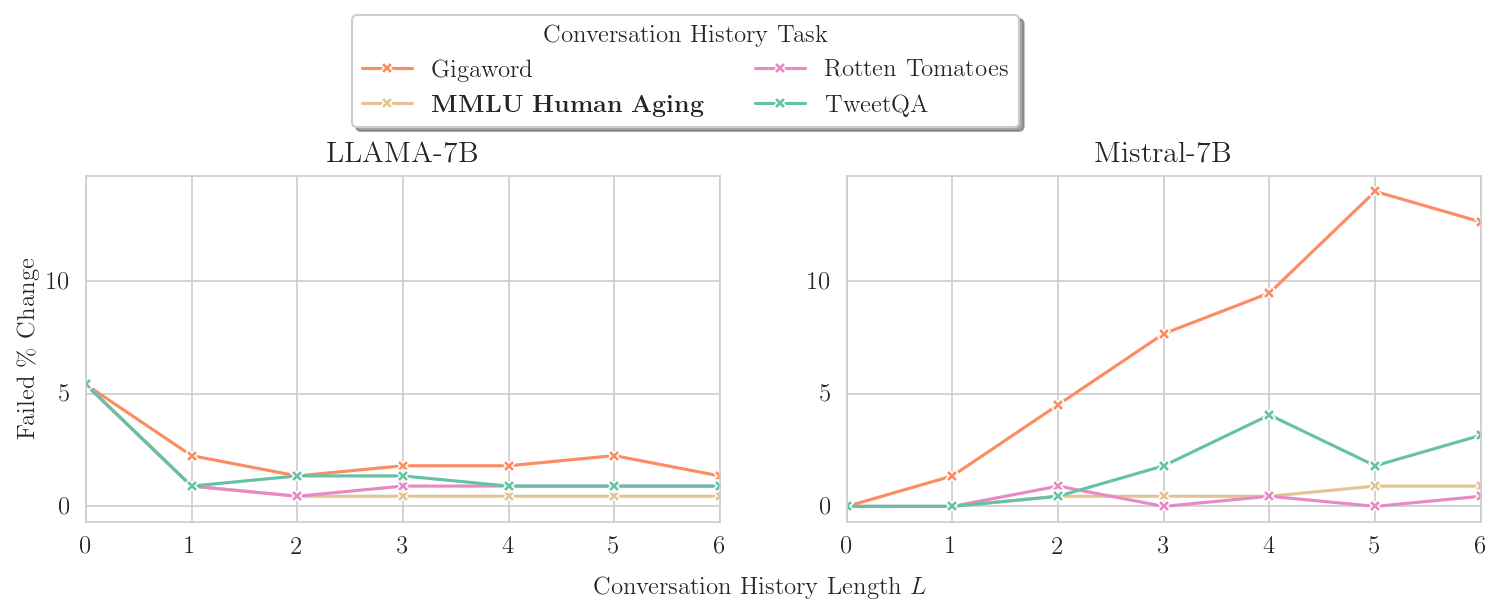

In [69]:
df = mmlu_age_df
df["perc_fail"] = df["failed"] / df["total"] * 100
df = df.rename(columns={"perc_fail": r"Failed \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Failed \% Change"], 
  save_path=Path("mmlu-age/fail_rate.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.8, 1.5),
)

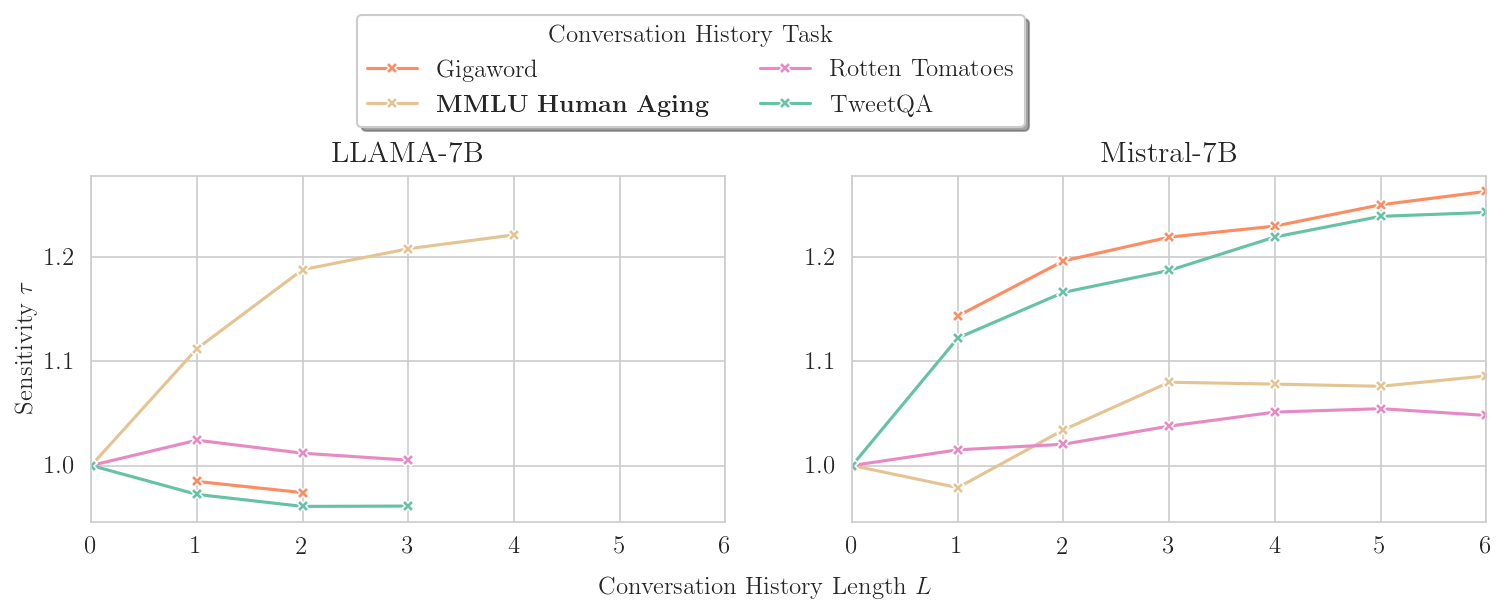

In [70]:
label = r"Sensitivity $\tau$"
df = mmlu_age_df
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
df = sensitivity(df)
df = df.rename(columns={"sensitivity": label})
plot_df_metrics_per_model(
    df,
    [label],
    save_path=Path("mmlu-age/sensitivity.pdf"),
    # title="MMLU Abstract Algebra Results",
    eval_set="mmlu-age",
    legend_axs=(-1, 1),
    legend_anchor=(-0.8, 1.5),
)

In [71]:
df.columns

Index(['matches', 'failed', 'total', 'model', 'incontext_set', 'num_examples',
       'base_likelihood', 'acc', 'acc_pct_change', 'perc_fail',
       'Sensitivity $\tau$'],
      dtype='object')

In [72]:
# zero shot results
df = mmlu_age_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="mmlu-age",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
LLAMA-7B & 45.50 & 12 \\
Mistral-7B & 55.41 & 0 \\


## Evaluate on MMLUAA

In [73]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset("mmluaa", aa_ref_data, use_cached=True)
aa_results_df = pd.DataFrame(aa_results)

print(len(aa_results_df))
aa_results_df.head()

Skipping ../experiments/gpt3.5/eval_data_mmluaa/incontext_data_mmluaa/num_examples_5
111


,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,23,1,99,mistral-7b,rotten_tomatoes,3,-1.169420
1,26,0,99,mistral-7b,rotten_tomatoes,6,-1.181519
2,22,0,99,mistral-7b,rotten_tomatoes,0,-1.140825
3,26,0,99,mistral-7b,rotten_tomatoes,4,-1.186017
4,24,0,99,mistral-7b,rotten_tomatoes,2,-1.148963


In [74]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")

aa_results_df = sensitivity(aa_results_df)
# aa_results_df.head()

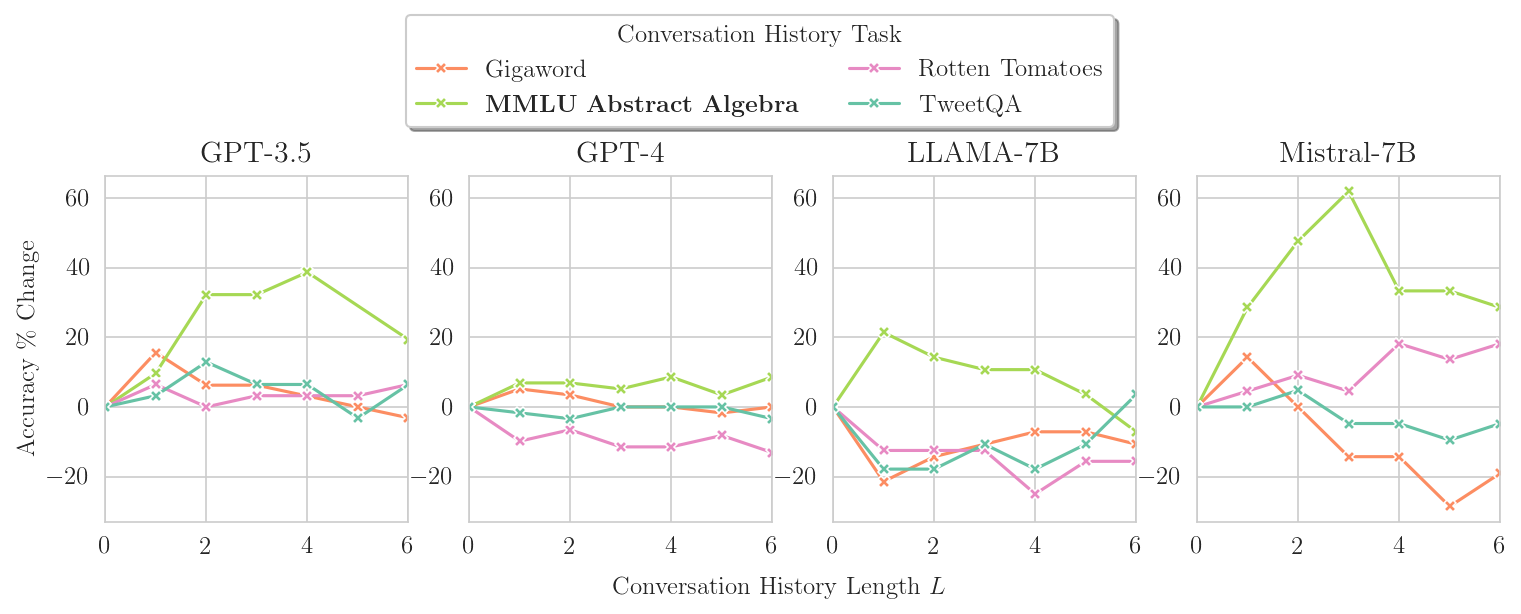

In [75]:
label = r"Accuracy \% Change"

df = aa_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("mmluaa/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
)

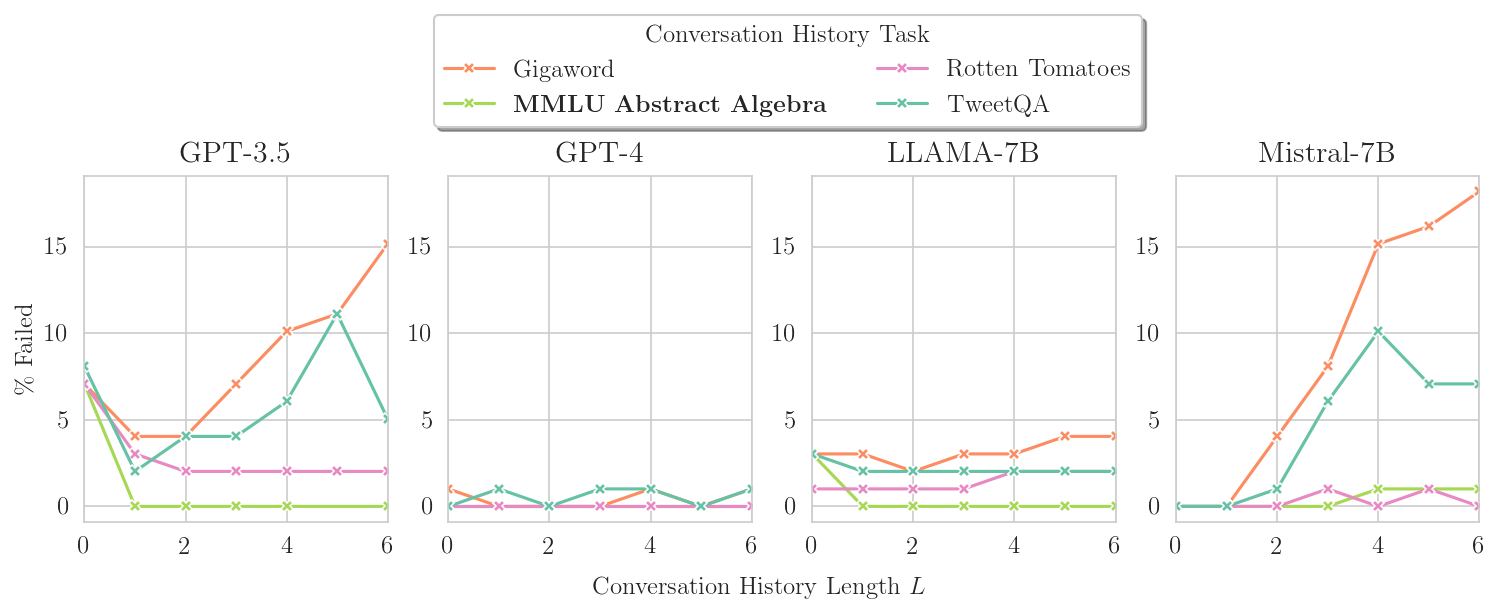

In [76]:
aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
df = aa_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("mmluaa/fail_rate.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(1.11, 1.5),
)

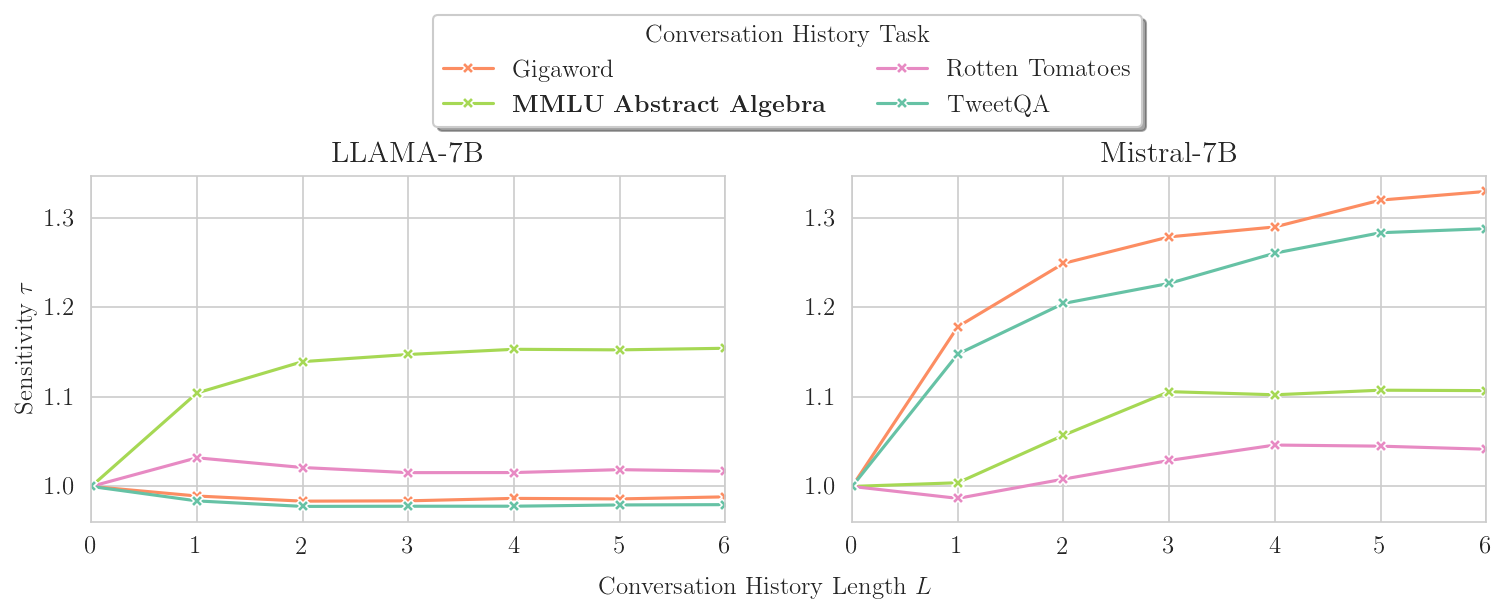

In [77]:
# aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
label = r"Sensitivity $\tau$"
df = aa_results_df.rename(columns={"sensitivity": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("mmluaa/sensitivity.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(0.52, 1.5),
)

In [78]:
# Results table

df = aa_results_df
df = df.rename(
    columns={
        r"sensitivity": r"$\tau(\cdot)$",
        r"acc_pct_change": r"\% Change",
    }
)
results_latex_table(
    df,
    [r"\% Change", r"$\tau(\cdot)$"],
    task="mmluaa",
    num_examples=6,
)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
MMLU Abstract Algebra 
& GPT-3.5 & \emph{19.35} & {-} \\
& GPT-4 & \emph{8.62} & {-} \\
& LLAMA-7B & \emph{-7.14} & \emph{1.15} \\
& Mistral-7B & \emph{28.57} & \emph{1.11} \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & -3.13 & {-} \\
& GPT-4 & 0.00 & {-} \\
& LLAMA-7B & -10.71 & 0.99 \\
& Mistral-7B & -19.05 & 1.33 \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & 6.45 & {-} \\
& GPT-4 & -13.11 & {-} \\
& LLAMA-7B & -15.63 & 1.02 \\
& Mistral-7B & 18.18 & 1.04 \\
\midrule
TweetQA 
& GPT-3.5 & 6.45 & {-} \\
& GPT-4 & -3.39 & {-} \\
& LLAMA-7B & 3.57 & 0.98 \\
& Mistral-7B & -4.76 & 1.29 \\


In [80]:
# Zero shot results on MMLU Abstract Algebra

df = aa_results_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="mmluaa",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
GPT-3.5 & 31.31 & 7 \\
GPT-4 & 58.59 & 0 \\
LLAMA-7B & 28.28 & 3 \\
Mistral-7B & 21.21 & 0 \\


## Evaluate on Rotten Tomatoes

In [25]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset("rotten_tomatoes", rt_reference_data, use_cached=False)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Reference: negative:
Prediction:  <answer> neutral </answer>.
Generation format failed for 0.093809%           (1/1066 samples)
Reference probabilities not found at ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_0/iterative/base_probabilities.pkl
Reference: positive:
Prediction: <answer> neutral </answer>.
Generation format failed for 0.093809%           (1/1066 samples)
Reference probabilities not found at ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_4/iterative/base_probabilities.pkl
Reference: negative:
Prediction: <answer> neutral </answer>.
Reference: negative:
Prediction: <answer> neutral </answer>.
Generation format failed for 0.187617%           (2/1066 samples)
Reference probabilities not fo

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,924,1,1066,mistral-7b,dailymail,0,NaN
1,892,1,1066,mistral-7b,dailymail,4,NaN
2,898,2,1066,mistral-7b,dailymail,2,NaN
3,970,0,1066,mistral-7b,rotten_tomatoes,10,NaN
4,959,2,1066,mistral-7b,rotten_tomatoes,6,-4.166403


In [26]:
# Calculate the percentage change in accuracy
rt_results_df["acc"] = rt_results_df["matches"] / rt_results_df["total"]
rt_results_df = df_metric_pct_change(rt_results_df, "acc")

# Calculate sensitivity
rt_results_df = sensitivity(rt_results_df)

# Remove llama dailymail num examples 4
rt_results_df = rt_results_df[
    ~((rt_results_df["model"] == "llama-7b") & (rt_results_df["num_examples"] == 4) & (rt_results_df["incontext_set"] == "dailymail"))
]
# remove incontext_set dailymail
rt_results_df = rt_results_df[rt_results_df["incontext_set"] != "dailymail"]

rt_results_df.head()

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,acc,acc_pct_change,sensitivity
3,970,0,1066,mistral-7b,rotten_tomatoes,10,NaN,0.909944,4.978355,NaN
4,959,2,1066,mistral-7b,rotten_tomatoes,6,-4.166403,0.899625,3.787879,1.970986
5,924,1,1066,mistral-7b,rotten_tomatoes,0,-3.487870,0.866792,0.000000,1.000000
6,956,1,1066,mistral-7b,rotten_tomatoes,4,-4.215975,0.896811,3.463203,2.071154
7,943,0,1066,mistral-7b,rotten_tomatoes,2,-4.083625,0.884615,2.056277,1.814402


In [27]:
len(rt_results_df[rt_results_df["base_likelihood"].notna()])

32

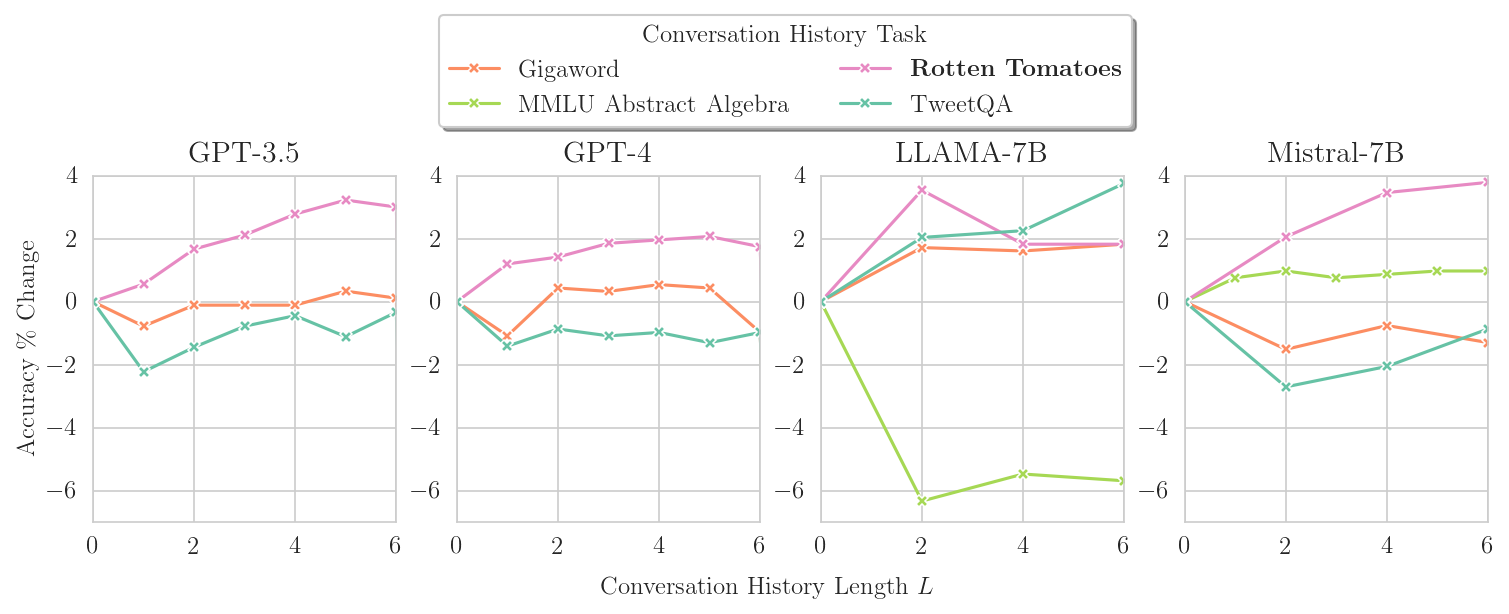

In [28]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.5),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 2),
)

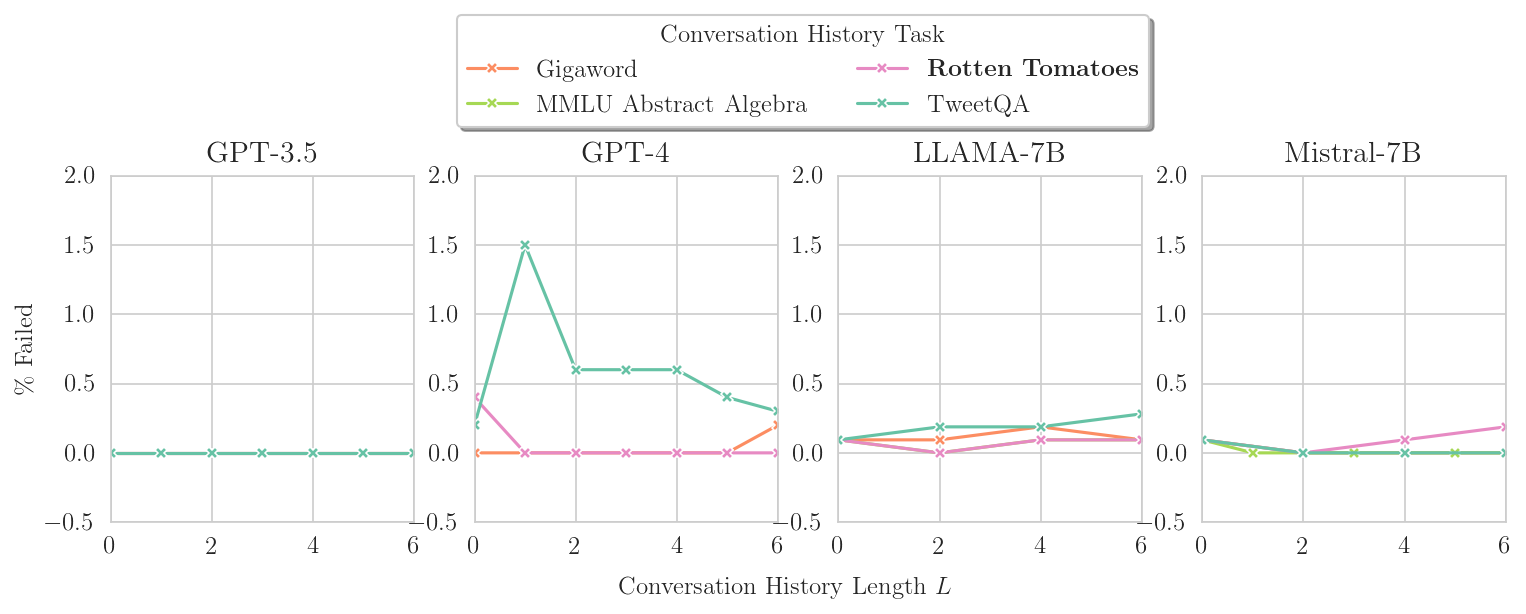

In [29]:
rt_results_df["perc_fail"] = rt_results_df["failed"] / rt_results_df["total"] * 100
df = rt_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("rt/fail_rate.pdf"), 
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.5),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-0.5, 2),
  legend_axs=(-1, 2),
)

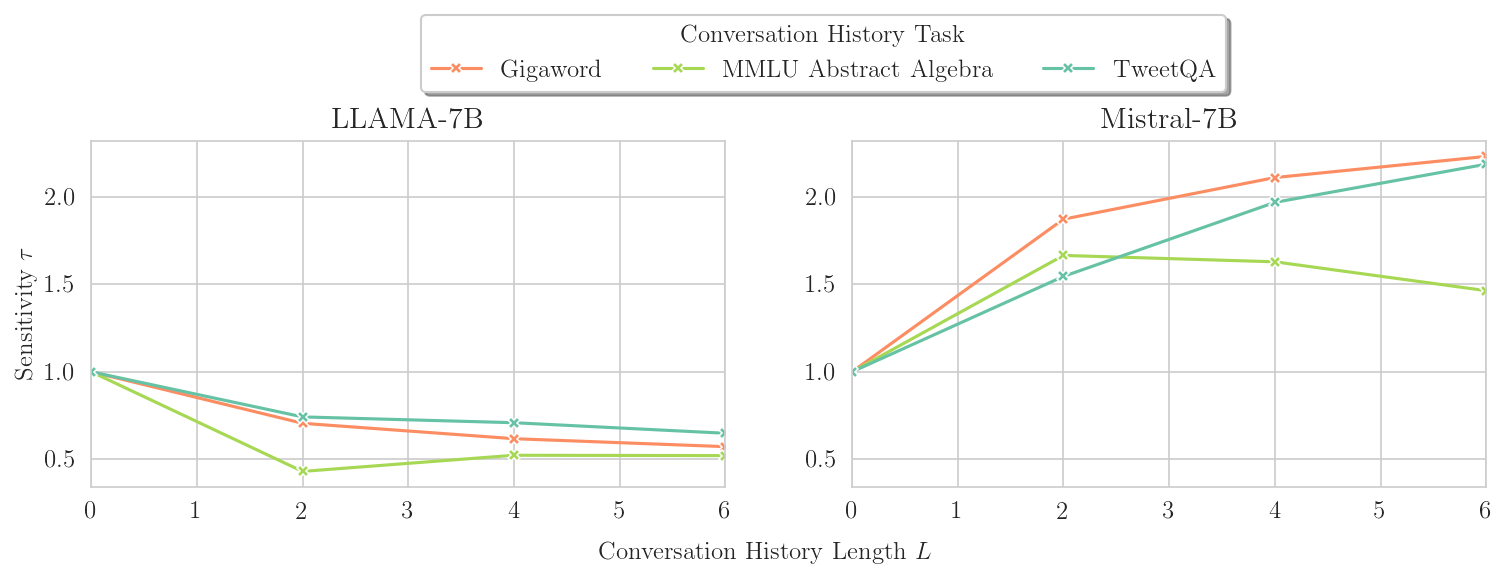

In [30]:
label = r"Sensitivity $\tau$"

df = rt_results_df.rename(columns={"sensitivity": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
# remove the incontext = task
df = df[df["incontext_set"] != "rotten_tomatoes"]

plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("rt/sensitivity.pdf"), 
  eval_set="rotten_tomatoes",
  legend_anchor=(0.5, 1.4),
  legend_rows=1
)

In [65]:
# Zero shot results table

df = rt_results_df

columns = {
    "acc": "Accuracy",
    "failed": r"\# Format Errors",
}
df = df.rename(columns=columns)

# Multiple accuracy by 100
df["Accuracy"] *= 100
# round to 2 decimal places
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x, 2))

zero_shot_latex_table(
    df,
    columns=columns.values(),
    task="rotten_tomatoes",
    num_examples=0,
    fmts=[".2f", ".0f"],
)

Model & {Accuracy} & {\# Format Errors} \\
\midrule
GPT-3.5 & 89.90 & 0 \\
GPT-4 & 91.80 & 4 \\
LLAMA-7B & 87.43 & 1 \\
Mistral-7B & 86.68 & 1 \\


In [33]:
# Main Results Table

df = rt_results_df

# remove in_context dailymail
df = df[~((df["incontext_set"] == "dailymail"))]
columns={
    r"acc_pct_change": r"\% Change",
    r"sensitivity": r"$\tau(\cdot)$",
}

df = df.rename(columns=columns)

results_latex_table(
    df,
    columns.values(),
    task="rotten_tomatoes",
    num_examples=6,
)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & \emph{3.00} & {-} \\
& GPT-4 & \emph{1.74} & {-} \\
& LLAMA-7B & \emph{1.82} & \emph{0.24} \\
& Mistral-7B & \emph{3.79} & \emph{1.97} \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & 0.11 & {-} \\
& GPT-4 & -0.98 & {-} \\
& LLAMA-7B & 1.82 & 0.57 \\
& Mistral-7B & -1.30 & 2.23 \\
\midrule
MMLU Abstract Algebra 
& LLAMA-7B & -5.69 & 0.52 \\
& Mistral-7B & 0.97 & 1.46 \\
\midrule
TweetQA 
& GPT-3.5 & -0.33 & {-} \\
& GPT-4 & -0.98 & {-} \\
& LLAMA-7B & 3.76 & 0.65 \\
& Mistral-7B & -0.87 & 2.19 \\


## Evaluate on TweetQA

In [85]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()
tq_results = get_results_for_evalset("tweetqa", tq_reference_data, use_cached=True)
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")
tq_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_5
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/nu

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples,base_likelihood
0,0.280442,0.146321,0.277731,0.277150,0.427295,mistral-7b,dailymail,3,None
1,0.253541,0.126042,0.250111,0.249536,0.407057,mistral-7b,dailymail,0,None
2,0.280660,0.144863,0.278590,0.278256,0.425253,mistral-7b,dailymail,4,None
3,0.284807,0.145588,0.282203,0.281575,0.429017,mistral-7b,dailymail,2,None
4,0.279596,0.140991,0.277848,0.277102,0.426147,mistral-7b,dailymail,5,None


In [86]:
# Remove the incontext dailymail
tq_results_df = tq_results_df[~((tq_results_df["incontext_set"] == "dailymail"))]

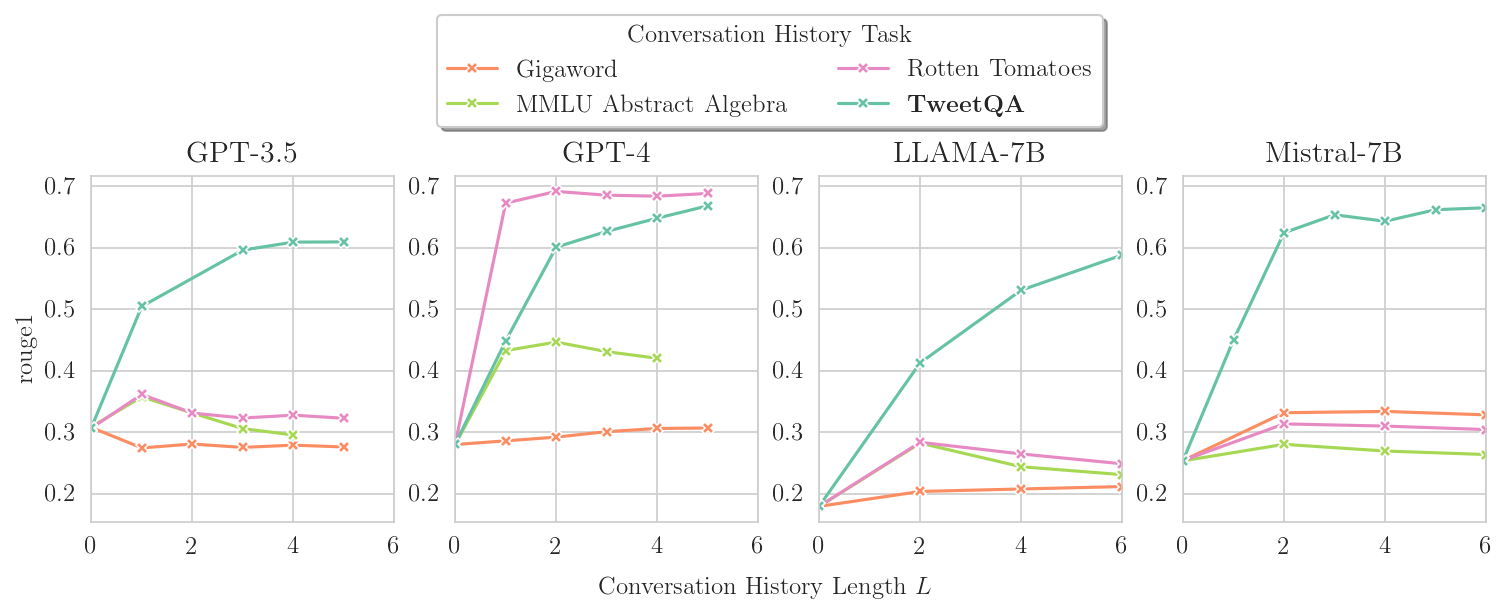

In [87]:
plot_df_metrics_per_model(
  tq_results_df, 
  ["rouge1"], 
  eval_set="tweetqa",
  legend_anchor=(-1.3, 1.5),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 2),
)

In [88]:
tq_results_df.columns

Index(['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'meteor', 'model',
       'incontext_set', 'num_examples', 'base_likelihood'],
      dtype='object')

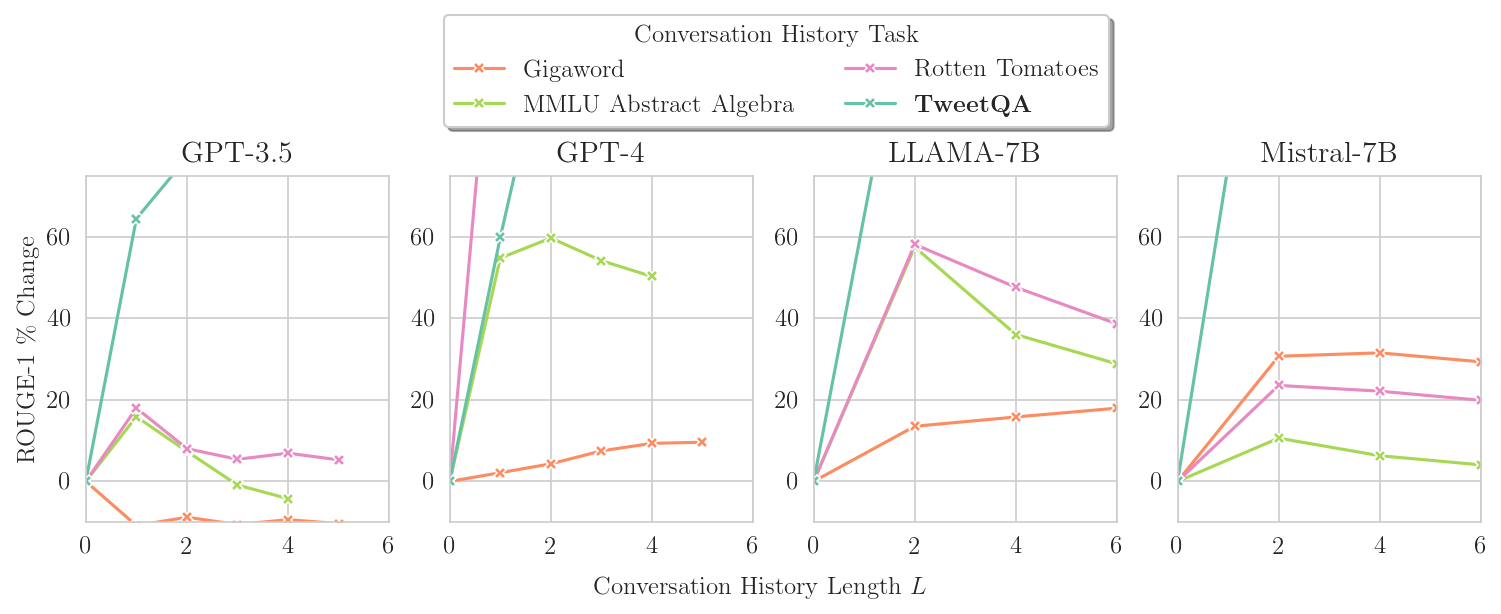

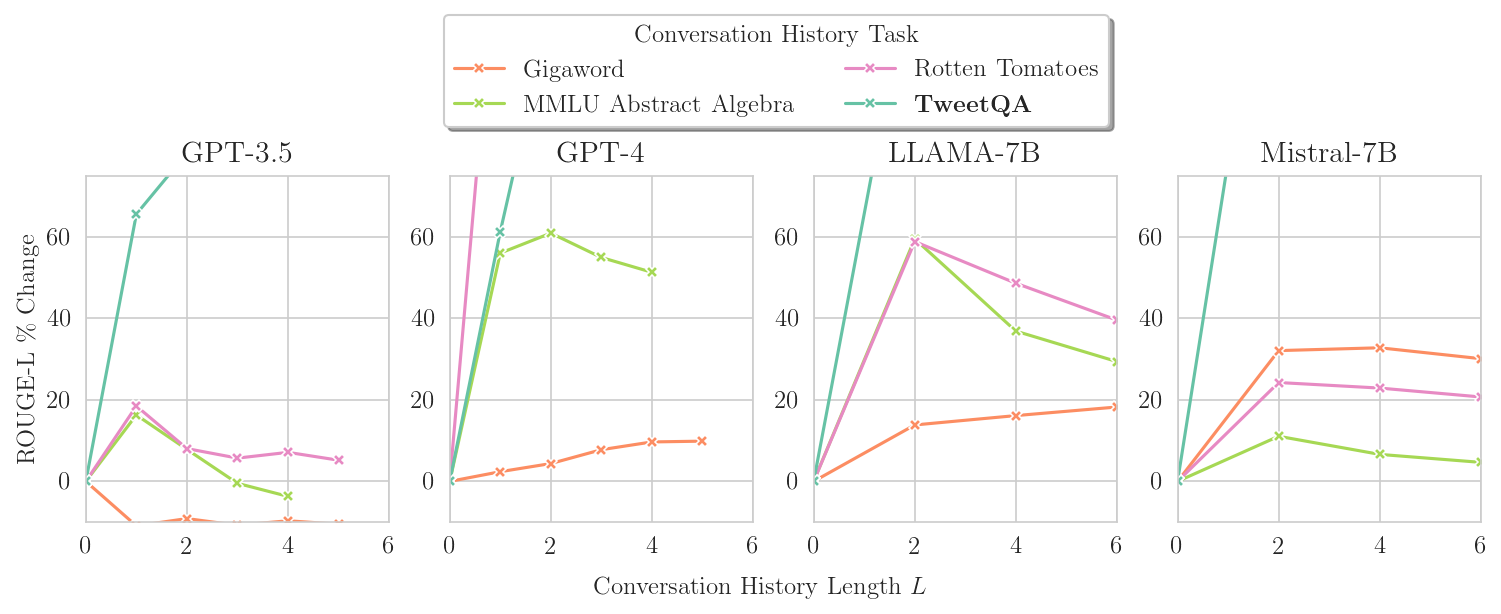

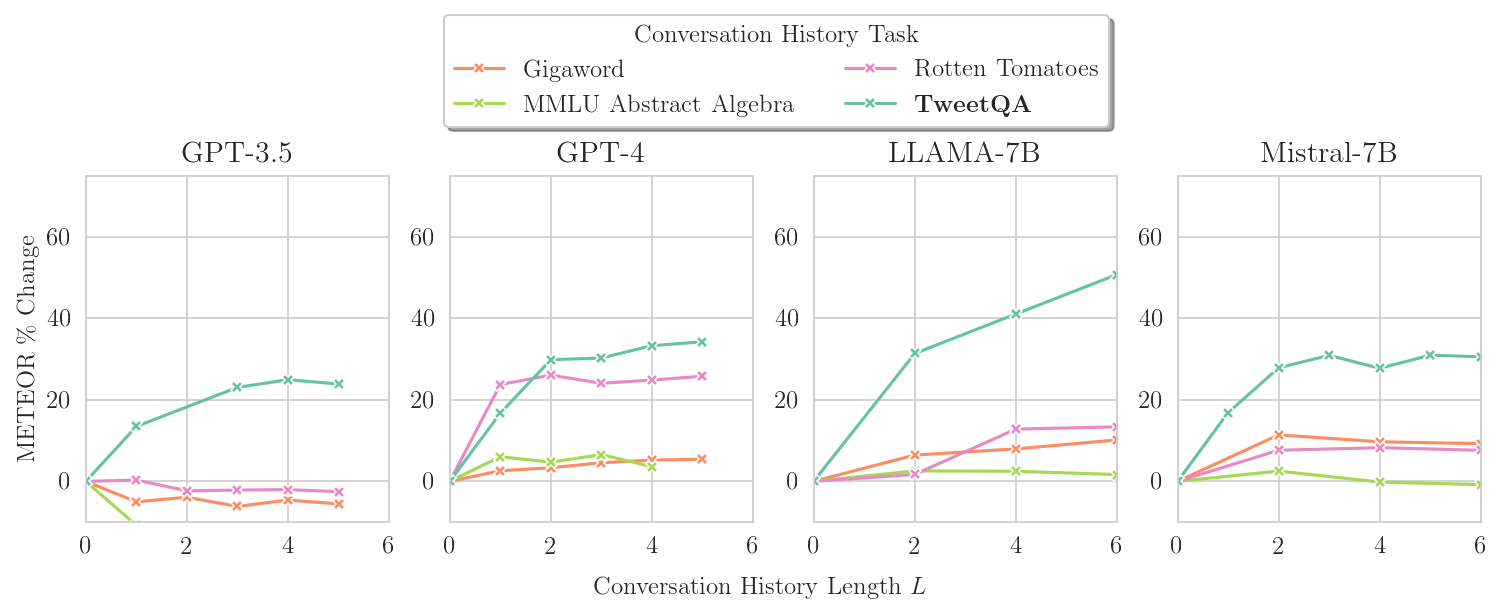

In [89]:
# Plot percentage change in metrics (1 graph per metric)

df = tq_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rougeL")
df = df_metric_pct_change(df, "meteor")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
    "meteor_pct_change": r"METEOR \% Change",
}

df = df.rename(columns=labels)

for metric in labels.values():
    plot_df_metrics_per_model(
        df,
        [metric],
        save_path=Path(f"tweetqa/{metric.split()[0]}.pdf"),
        eval_set="tweetqa",
        legend_anchor=(1.14, 1.5),
        adjust_func=lambda axs: axs[0, 0].set_ylim(-10, 75),
        legend_axs=(0, 0),
    )

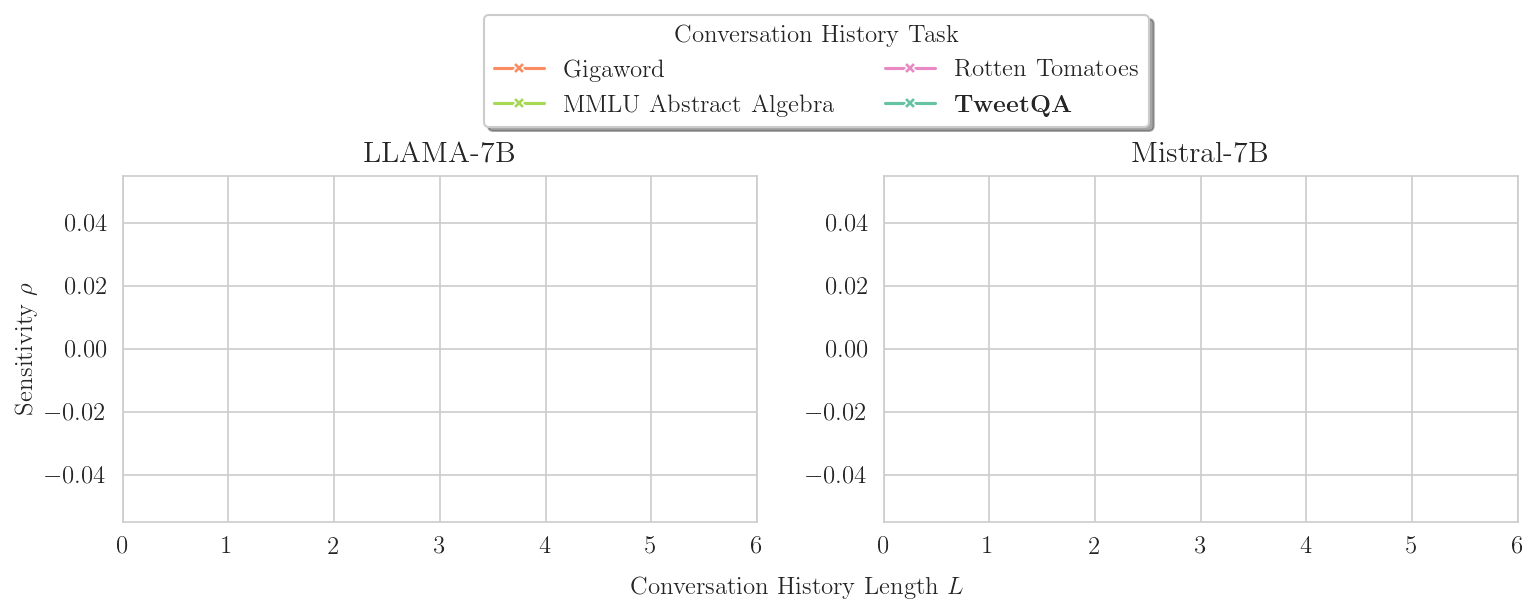

In [90]:
# Plot sensitivity rho

label = r"Sensitivity $\rho$"
df = tq_results_df.rename(columns={"base_likelihood": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("tq_sensitivity.pdf"), 
  eval_set="tweetqa",
  legend_anchor=(0.55, 1.5),
  legend_axs=(0,0)
)

In [91]:
# Zero shot results table

df = tq_results_df

columns = {
    "rouge1": "ROUGE-1",
    "rougeL": "ROUGE-L",
    "meteor": "METEOR",
}
df = df.rename(columns=columns)

for col in columns.values():
    df[col] = df[col] * 100

zero_shot_latex_table(df, columns=columns.values(), task="tweetqa", num_examples=0)


Model & {ROUGE-1} & {ROUGE-L} & {METEOR} \\
\midrule
GPT-3.5 & 30.66 & 30.39 & 44.18 \\
GPT-4 & 28.03 & 27.68 & 43.41 \\
LLAMA-7B & 17.91 & 17.67 & 33.84 \\
Mistral-7B & 25.35 & 25.01 & 40.71 \\


## Gigaword set

In [81]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()
gw_results = get_results_for_evalset("gigaword", gw_reference_data, use_cached=True)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_3
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_15
Skipping ../experiments/llama-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_gigaword/in

In [82]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))

# remove in_context dailymail
gw_results_df = gw_results_df[~((gw_results_df["incontext_set"] == "dailymail"))]

gw_results_df.head()

136


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,base_likelihood
6,0.188080,0.054284,0.160740,0.160751,197.596617,mistral-7b,rotten_tomatoes,10,NaN
7,0.190086,0.055322,0.162274,0.162257,193.060994,mistral-7b,rotten_tomatoes,6,NaN
8,0.185710,0.051803,0.158150,0.158175,203.721681,mistral-7b,rotten_tomatoes,0,NaN
9,0.191853,0.056348,0.164331,0.164319,190.101486,mistral-7b,rotten_tomatoes,4,NaN
10,0.196036,0.057439,0.167680,0.167576,185.599692,mistral-7b,rotten_tomatoes,2,NaN


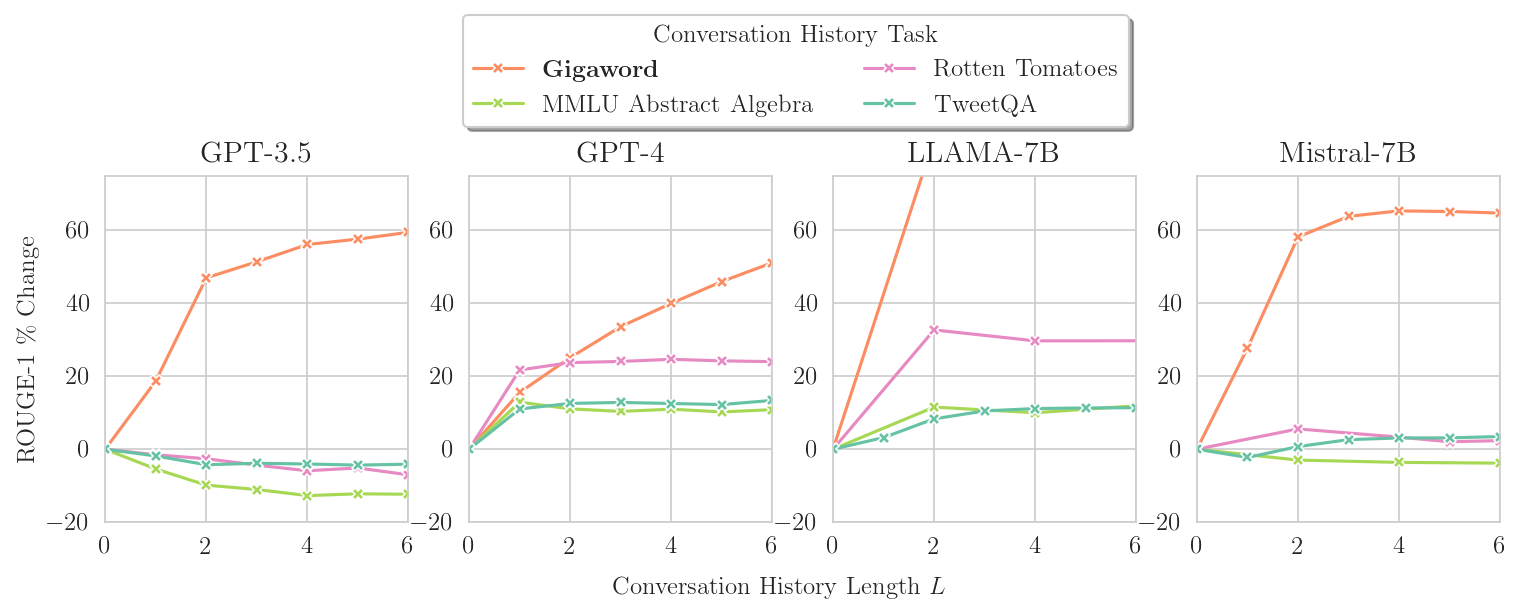

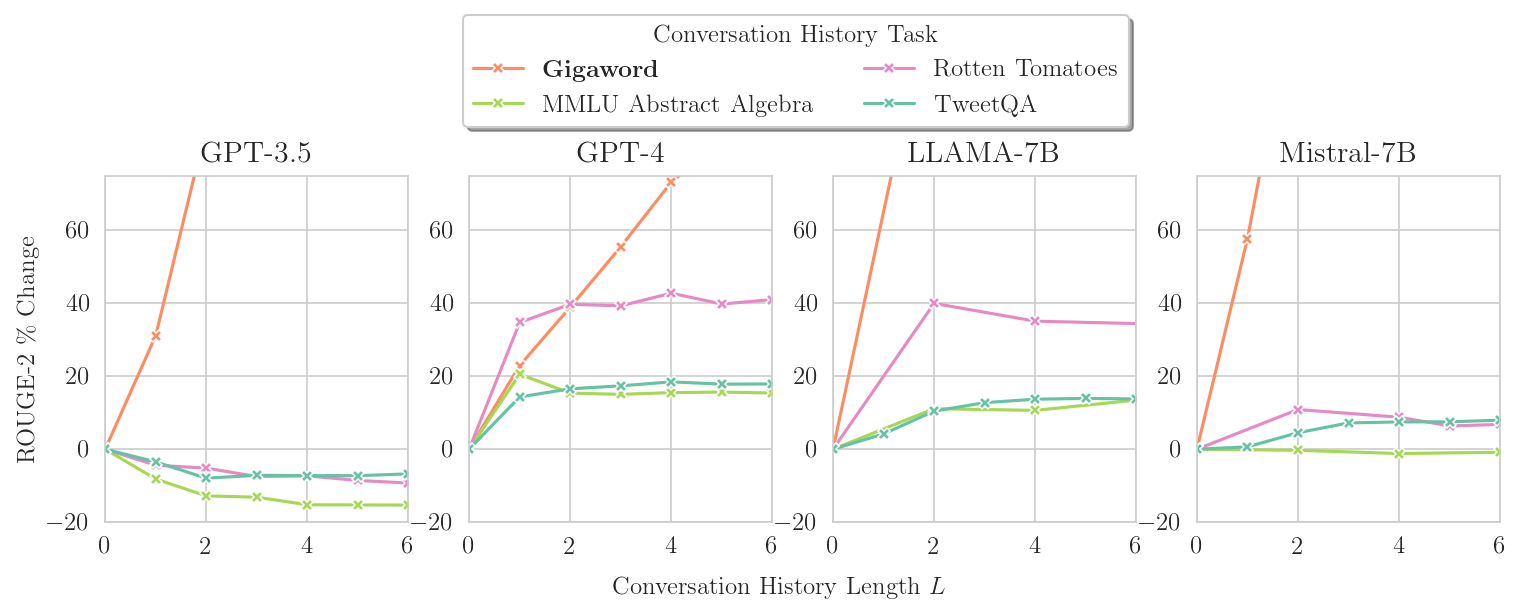

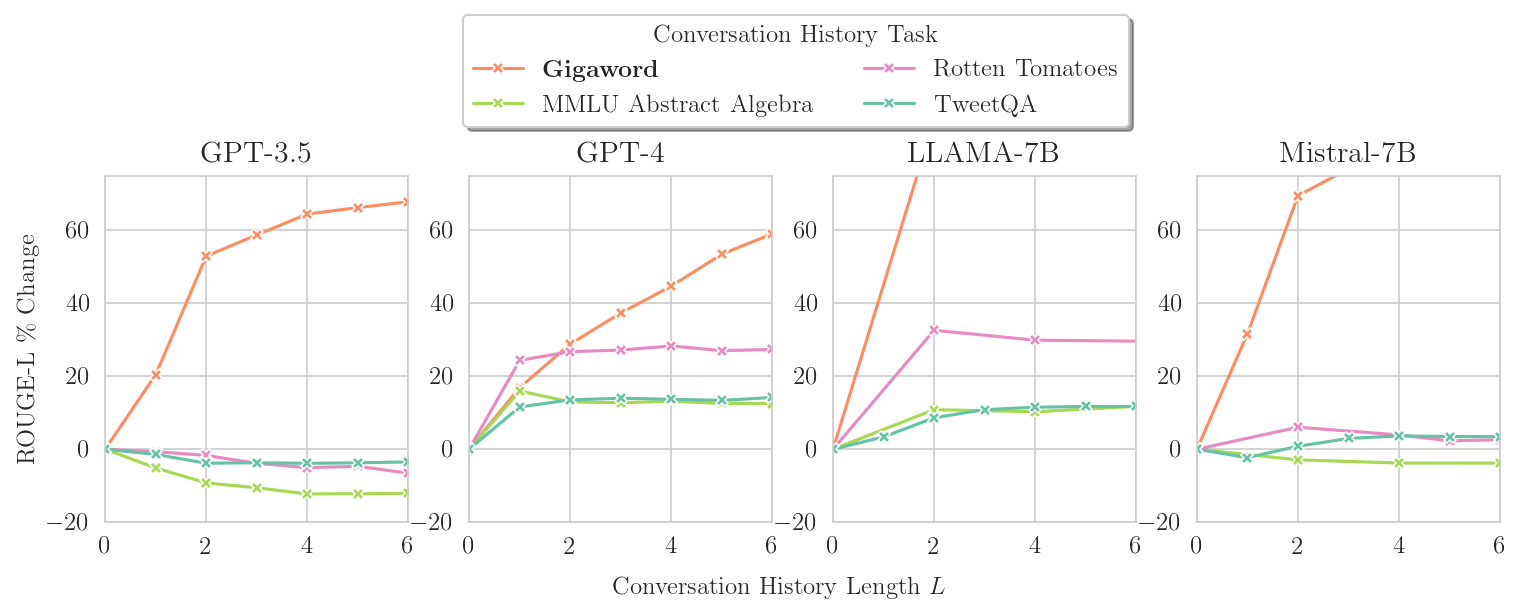

In [83]:
# Plot percentage change in metrics (1 graph per metric)

df = gw_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)

for metric in labels.values():
    plot_df_metrics_per_model(
        df,
        [metric],
        save_path=Path(f"gw/{metric.split()[0]}.pdf"),
        eval_set="gigaword",
        legend_anchor=(1.14, 1.5),
        adjust_func=lambda axs: axs[0, 0].set_ylim(-20, 75),
        legend_axs=(0, 0),
    )

In [84]:
# Zero shot results table

df = gw_results_df

columns={
    r"rouge1": r"ROUGE-1",
    r"rouge2": r"ROUGE-2",
    r"rougeL": r"ROUGE-L",
}

df = df.rename(columns=columns)

# Multiply by 100
for col in columns.values():
    df[col] = df[col] * 100

zero_shot_latex_table(df, columns=columns.values(), task="gigaword", num_examples=0)

Model & {ROUGE-1} & {ROUGE-2} & {ROUGE-L} \\
\midrule
GPT-3.5 & 17.37 & 4.79 & 14.78 \\
GPT-4 & 15.76 & 4.07 & 13.34 \\
LLAMA-7B & 11.61 & 3.13 & 9.90 \\
Mistral-7B & 18.60 & 5.19 & 15.84 \\


In [75]:
len(gw_results_df[gw_results_df["base_likelihood"].notna()])

6

## Evaluate on Dailymail Set

In [ ]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()
dm_results = get_results_for_evalset("dailymail", dm_reference_data, use_cached=False)
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()


Removing large training set examples
Original training set size:  287113
New Training set size:  258269
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3/iterative/base_probabilities.pkl
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_4/iterative/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_2/iterative/base_probabilities.pkl
Skipping ../experime

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,base_likelihood
0,0.346284,0.145557,0.226287,0.290030,813.963,mistral-7b,dailymail,3,None
1,0.343988,0.143211,0.225101,0.289051,881.994,mistral-7b,dailymail,6,None
2,0.343143,0.139812,0.220972,0.280646,778.065,mistral-7b,dailymail,0,None
3,0.346478,0.144145,0.227067,0.291628,887.419,mistral-7b,dailymail,4,None
4,0.343016,0.146151,0.225872,0.288050,909.117,mistral-7b,dailymail,2,None


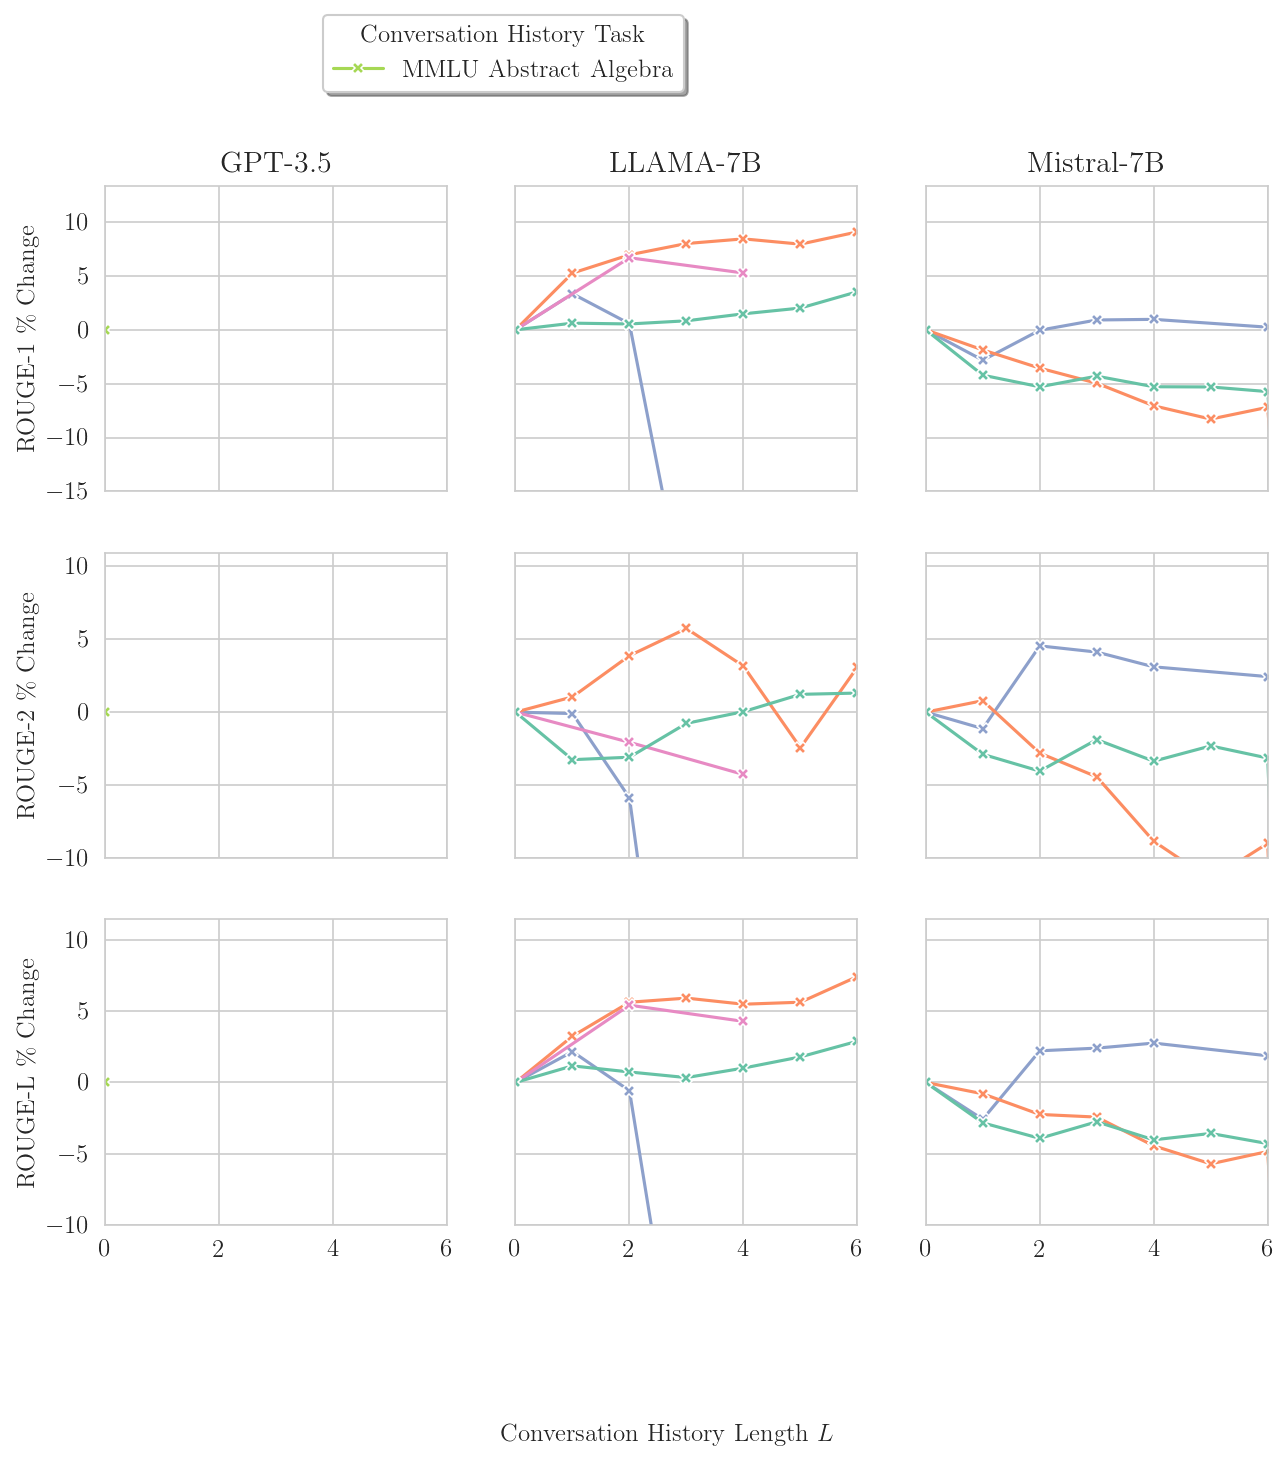

In [ ]:
# Plot percentage change in metrics

df = dm_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)
plot_df_metrics_per_model(
  df, 
  labels.values(), 
  # save_path=Path("dm_metrics.pdf"), 
  eval_set="dailymail",
  legend_anchor=(0.6, 1.6),
  adjust_func=lambda axs: (
    axs[0, 0].set_ylim(-15, None), 
    axs[1, 0].set_ylim(-10, None), 
    axs[2, 0].set_ylim(-10, None)
  ), 
  legend_axs=(0,0)
)

### Evaluate on GSM8K

In [ ]:
gsm8k = GSM8KDataLoader()
gsm8k_ref_data = gsm8k.load_test_reference()
gsm8k_results = get_results_for_evalset("gsm8k", gsm8k_ref_data, use_cached=True)
gsm8k_results_df = pd.DataFrame(gsm8k_results)

gsm8k_results_df["acc"] = gsm8k_results_df["matches"] / gsm8k_results_df["total"]

print(len(gsm8k_results_df))
gsm8k_results_df.head()

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

---Failed for Answer: 18/3
: Reference: 15
: Exception: could not convert string to float: '18/3'
---Failed for Answer: 8/7
: Reference: 8
: Exception: could not convert string to float: '8/7'
---Failed for Answer: 0.125+0.06666666666666667=0.19166666666666668
: Reference: 5
: Exception: could not convert string to float: '0.125+0.06666666666666667=0.19166666666666668'
---Failed for Answer: 72chairs68sofas
: Reference: 172
: Exception: could not convert string to float: '72chairs68sofas'
---Failed for Answer: Nosolution
: Reference: 300
: Exception: could not convert string to float: 'Nosolution'
---Failed for Answer: 3(x+7)
: Reference: 39
: Exception: could not convert string to float: '3(x+7)'
---Failed for Answer: x
: Reference: 80
: Exception: could not convert string to float: 'x'
---Failed for Answer: 64+48=112
: Reference: 112
: Exception: could not convert string to float: '64+48=112'
---Failed for Answer: 95.17glasses47.5plates
: Reference: 128
: Exception: could not convert 

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,acc
0,537,48,1319,mistral-7b,gsm8k,3,None,0.407127
1,151,35,1319,mistral-7b,gsm8k,0,None,0.114481
2,525,48,1319,mistral-7b,gsm8k,2,None,0.398029
3,497,51,1319,mistral-7b,gsm8k,1,None,0.376801
4,133,36,1319,mistral-7b,tweetqa,3,None,0.100834


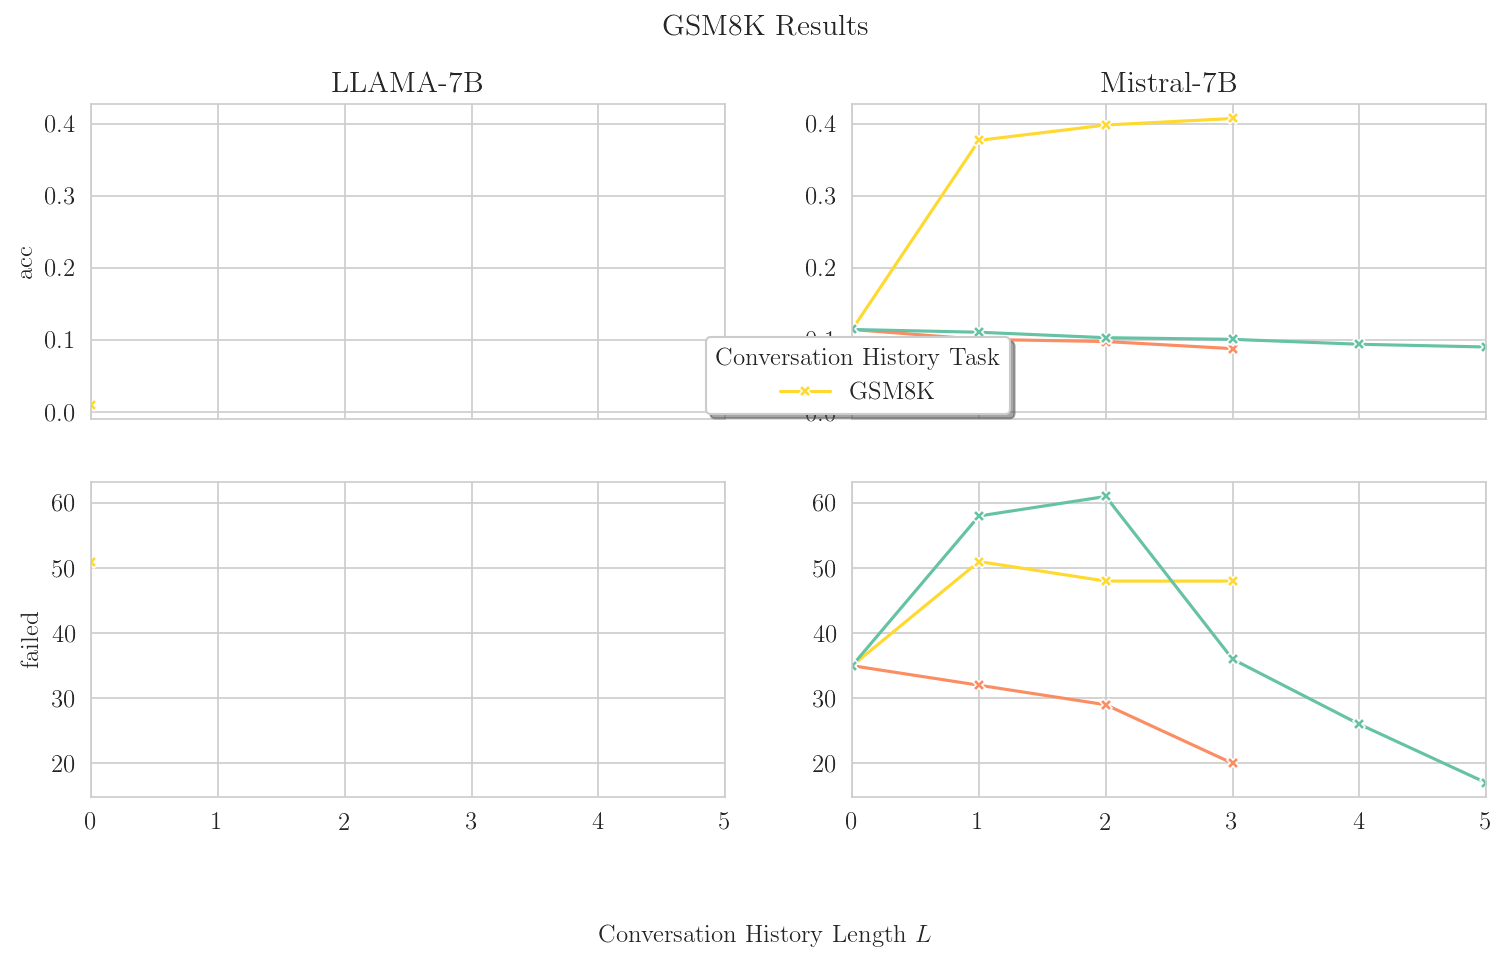

In [ ]:
plot_df_metrics_per_model(
  gsm8k_results_df, 
  ["acc", "failed"], 
  save_path=Path("gsm8k_results.pdf"), 
  title="GSM8K Results",
)

## .idea

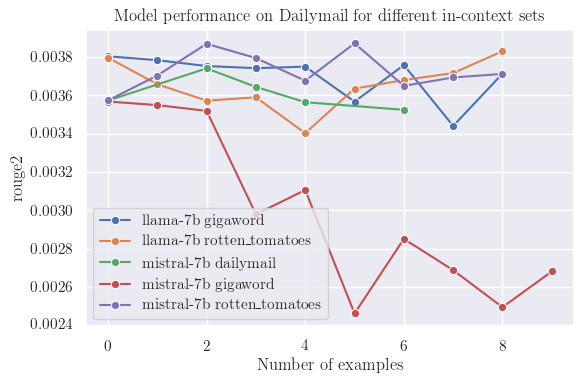

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge2"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

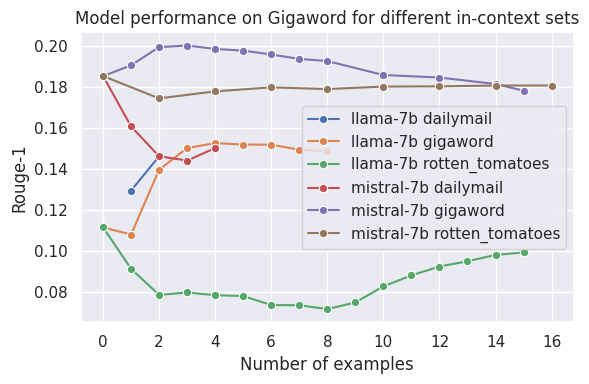

In [13]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

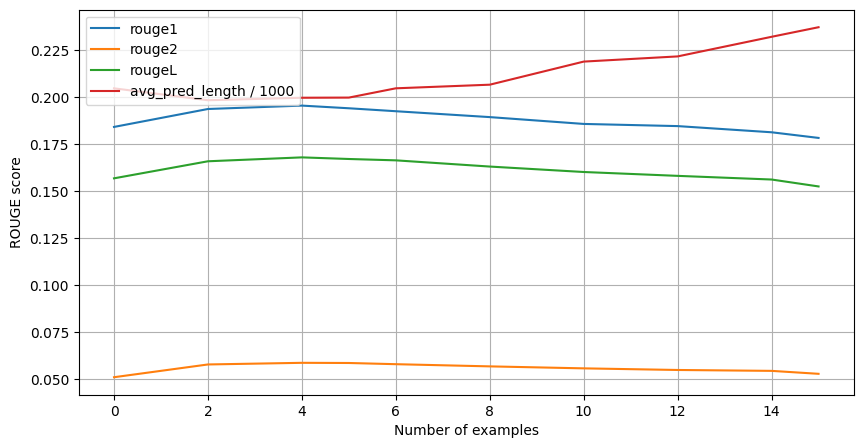

In [56]:
# Plot the results

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["num_examples"], df["rouge1"], label="rouge1")
ax.plot(df["num_examples"], df["rouge2"], label="rouge2")
ax.plot(df["num_examples"], df["rougeL"], label="rougeL")
ax.plot(df["num_examples"], df["avg_pred_length"] / 1000, label="avg_pred_length / 1000")
ax.set_xlabel("Number of examples")
ax.set_ylabel("ROUGE score")
ax.legend()
ax.grid()
fig.savefig("gigaword.png")
plt.show()

### Test evaluate

In [ ]:
pred_path = "/home/ag2118/rds/hpc-work/inctxt/inctxt/experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/predictions.json"

eval_idxs_file = Path(pred_path).parent / "eval_idxs.json"
if eval_idxs_file.is_file():
    ref_data = [dm_reference_data[i] for i in json.load(open(eval_idxs_file))]
else:
    ref_data = dm_reference_data
evaluate(pred_path, ref_data, use_cached=True)